# Checking if a pair of stocks is cointegrated

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import quiz_tests

In [2]:
# Set plotting options
%matplotlib inline
plt.rc('figure', figsize=(16, 9))

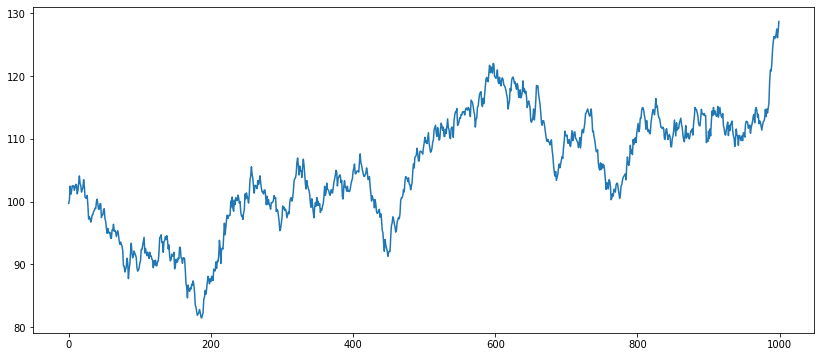

In [3]:
# just set the seed for the random number generator
np.random.seed(2018)
# use returns to create a price series
drift = 100
r1 = np.random.normal(0, 1, 1000) 
s1 = pd.Series(np.cumsum(r1), name='s1') + drift
s1.plot(figsize=(14,6))
plt.show()

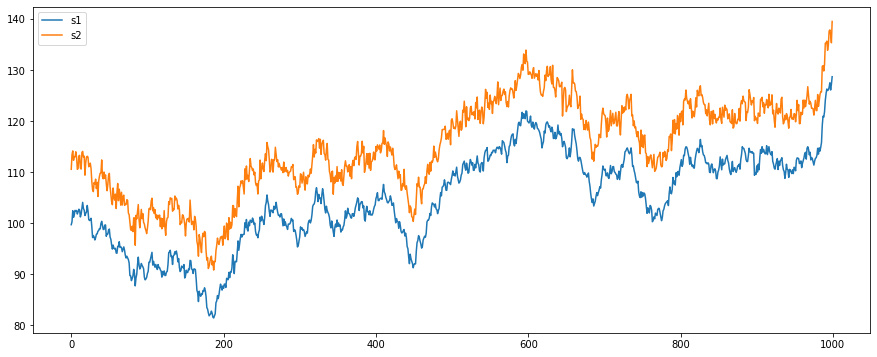

In [4]:
offset = 10
noise = np.random.normal(0, 1, 1000)
s2 = s1 + offset + noise
s2.name = 's2'
pd.concat([s1, s2], axis=1).plot(figsize=(15,6))
plt.show()

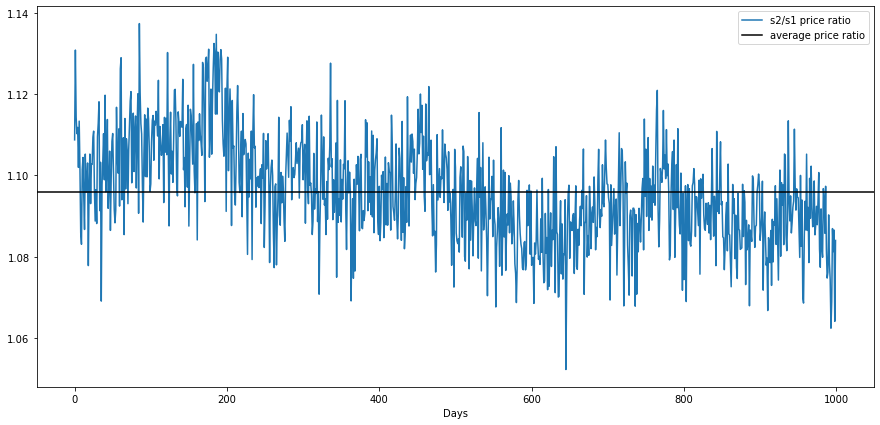

average price ratio 1.0960


In [5]:
price_ratio = s2/s1
price_ratio.plot(figsize=(15,7)) 
plt.axhline(price_ratio.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['s2/s1 price ratio', 'average price ratio'])
plt.show()
print(f"average price ratio {price_ratio.mean():.4f}")

## Calculate hedge ratio with regression

### Plot Stock 1 vs Stock 2 prices, to see to what extent they follow each other.

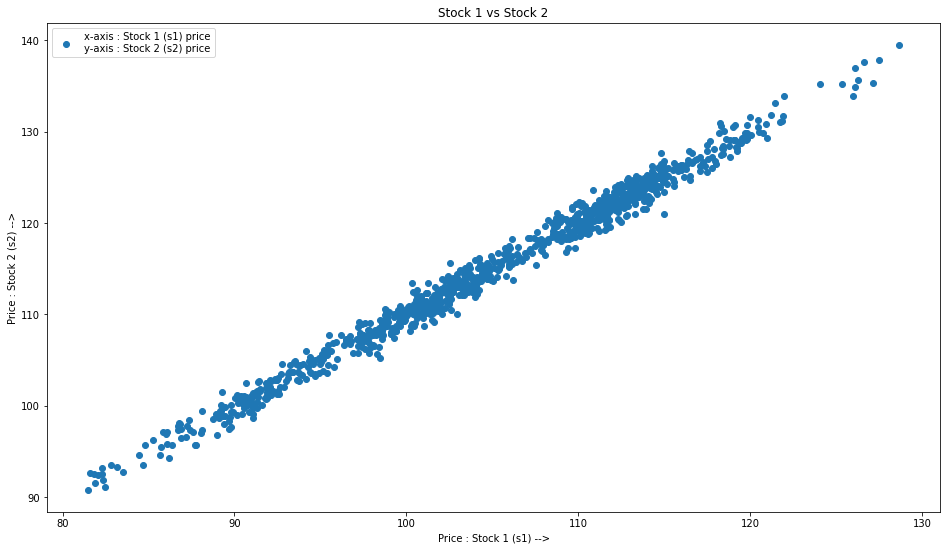

In [78]:
plt.scatter(s1, s2)
plt.title("Stock 1 vs Stock 2")
plt.xlabel("Price : Stock 1 (s1) -->")
plt.ylabel("Price : Stock 2 (s2) -->")
plt.legend(['x-axis : Stock 1 (s1) price\ny-axis : Stock 2 (s2) price'])
plt.show()

It is clear from the plot above, both the prices move in a linear fashion, and one can predict very much of variance of one stock from the other one.

## Linear Regression

Note that the LinearRegression().fit() expects 2D numpy arrays.  Since s1 and s2 are pandas series, we can use Series.values to get the values as a numpy array. Since these are 1D arrays, we can use numpy.reshape(-1,1) to make these 1000 row by 1 column 2 dimensional arrays

In [31]:
type(s1)

pandas.core.series.Series

In [32]:
type(s1.values)

numpy.ndarray

In [33]:
s1.values.reshape(-1,1).shape

(1000, 1)

In [34]:
lr = LinearRegression()
lr.fit(s1.values.reshape(-1,1),s2.values.reshape(-1,1))

LinearRegression()

In [35]:
hedge_ratio = lr.coef_[0][0]
hedge_ratio

1.002234357791276

In [36]:
intercept = lr.intercept_[0]
intercept

9.753022747192901

In [37]:
print(f"hedge ratio from regression is {hedge_ratio:.4f}, intercept is {intercept:.4f}")

hedge ratio from regression is 1.0022, intercept is 9.7530


### We can show the linear regression line on our plot above (Stock 1 vs Stock 2 prices).

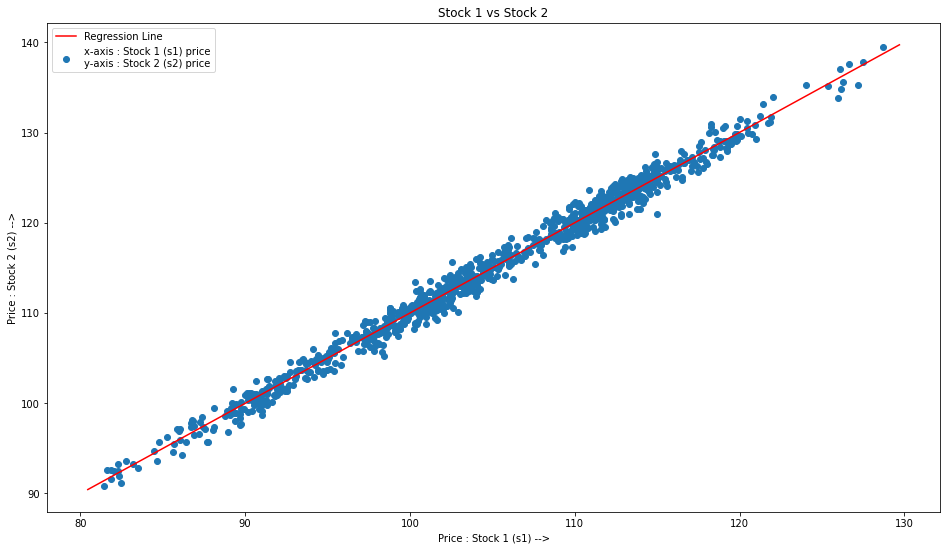

In [76]:
x1, y1 = min(s1.values)-1, (hedge_ratio*(min(s1.values)-1) + intercept)
x2, y2 = max(s1.values)+1, (hedge_ratio*(max(s1.values)+1) + intercept)

plt.scatter(s1, s2)
plt.plot([x1, x2], [y1, y2], color='red')
plt.title("Stock 1 vs Stock 2")
plt.xlabel("Price : Stock 1 (s1) -->")
plt.ylabel("Price : Stock 2 (s2) -->")
plt.legend(['Regression Line', 'x-axis : Stock 1 (s1) price\ny-axis : Stock 2 (s2) price'])
plt.show()

## Question
Do you think we'll need the intercept when calculating the spread?  Why or why not?
 
## Answer
Since the intercept is a constant, it's not necesary to include it in the spread, since it just shifts the spread up by a constant.  We use the spread to check when it deviates from its historical average, so what matters going foward is how the spread differs from this average.

## Calculate the spread

In [80]:
spread = s2 - s1 * hedge_ratio

In [81]:
print(f"Average spread is {spread.mean()}")

Average spread is 9.753022747192906


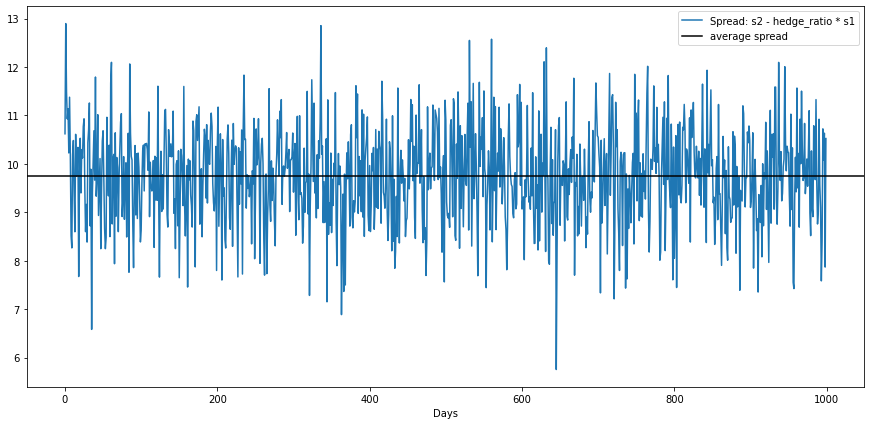

In [82]:
spread.plot(figsize=(15,7)) 
plt.axhline(spread.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['Spread: s2 - hedge_ratio * s1', 'average spread'])
plt.show()

0     10.61970853
1     12.89533500
2     11.48384627
3     10.92759056
4     11.13852970
          ...    
995   10.72144323
996   10.07342109
997   10.63187796
998    7.86826029
999   10.52166227
Length: 1000, dtype: float64
0     9.75302275
1     9.75302275
2     9.75302275
3     9.75302275
4     9.75302275
         ...    
995   9.75302275
996   9.75302275
997   9.75302275
998   9.75302275
999   9.75302275
Length: 1000, dtype: float64
-8.384404281969182e-13


/Users/apoorvmalik/opt/anaconda3/envs/algotrade/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


array([0.14652417, 0.33505703, 0.52647412, 0.66881956, 0.7429245 ,
       0.74750231, 0.66019748, 0.67162792, 0.75501506, 0.67504272,
       0.68363494, 0.73934576, 0.66497824, 0.71440875, 0.77437613,
       0.80469984, 0.78001257, 0.82639303, 0.86765358, 0.87885322])

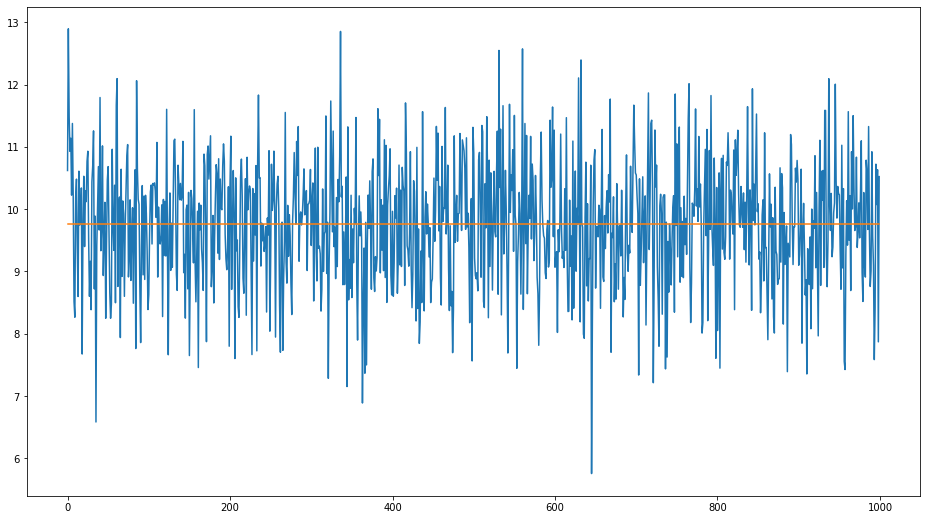

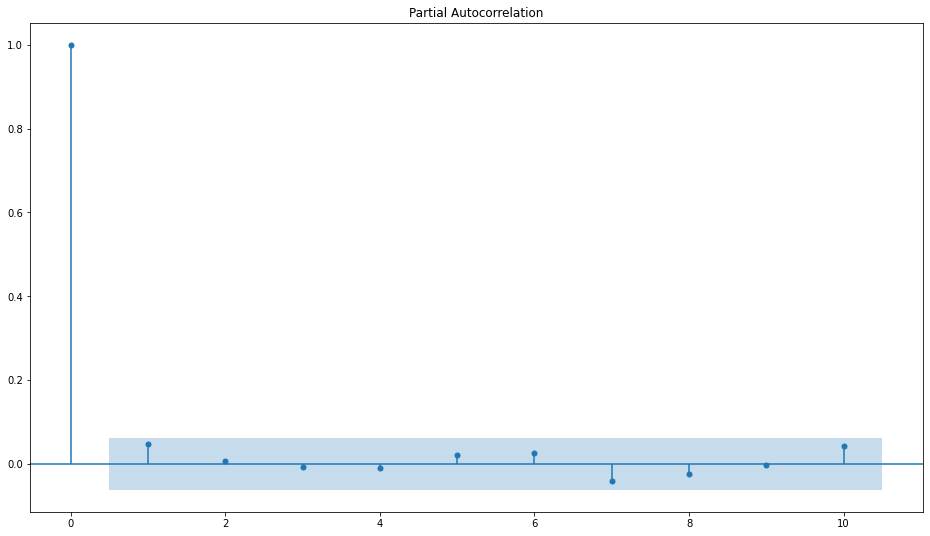

In [114]:
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(spread, lags=0, old_names=False)
ar_result = ar_model.fit()
ar_pred = ar_result.fittedvalues

print(spread)
print(ar_pred)

print(sum((spread-ar_pred).dropna()))

plt.plot(spread)
plt.plot(ar_pred)

from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_pacf(spread, lags=10)

from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test_stat, lb_p_value = acorr_ljungbox(spread,lags=20)
lb_p_value

## Let's see what we get if we include the intercept of the regression

In [18]:
spread_with_intercept = s2 - (s1 * hedge_ratio + intercept)
print(f"Average spread with intercept included is {spread_with_intercept.mean()}")

Average spread with intercept included is 6.210143510543276e-15


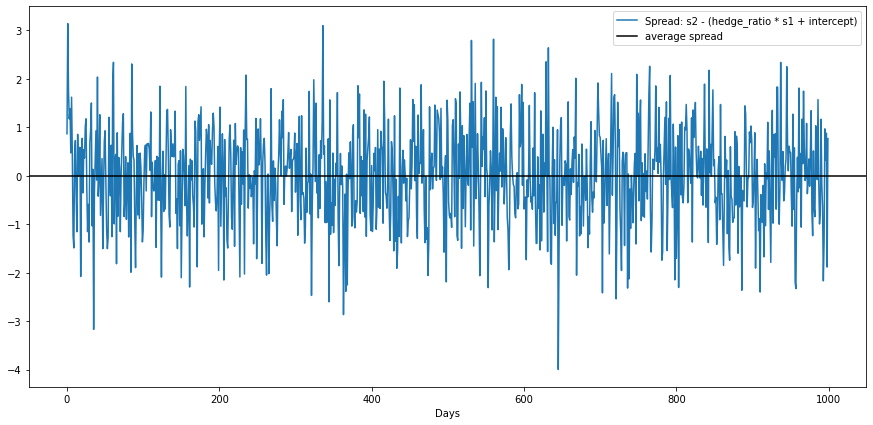

In [19]:
spread_with_intercept.plot(figsize=(15,7)) 
plt.axhline(spread_with_intercept.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['Spread: s2 - (hedge_ratio * s1 + intercept)', 'average spread'])
plt.show()

## Quiz
### Check if spread is stationary using Augmented Dickey Fuller Test

The [adfuller](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) function is part of the statsmodel library.

```
adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)[source]

adf (float) – Test statistic
pvalue (float) – p-value
...
```

In [20]:
def is_spread_stationary(spread, p_level=0.05):
    """
    spread: obtained from linear combination of two series with a hedge ratio
    
    p_level: level of significance required to reject null hypothesis of non-stationarity
    
    returns:
        True if spread can be considered stationary
        False otherwise
    """
    test_results = adfuller(spread)
    
    # adfuller function to check the spread
    adf_result = test_results[0]
    
    # get the p-value
    pvalue = test_results[1]
    
    print(f"pvalue {pvalue:.4f}")
    if pvalue <= p_level:
        print(f"pvalue is <= {p_level}, assume spread is stationary")
        return True
    else:
        print(f"pvalue is > {p_level}, assume spread is not stationary")
        return False
    
quiz_tests.test_is_spread_stationary(is_spread_stationary)

pvalue 0.0000
pvalue is <= 0.05, assume spread is stationary
Tests Passed


In [21]:
# Try out your function
print(f"Are the two series candidates for pairs trading? {is_spread_stationary(spread)}")

pvalue 0.0000
pvalue is <= 0.05, assume spread is stationary
Are the two series candidates for pairs trading? True
